In [1]:
!pip -q install geopandas shapely rasterio pyproj tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/CASA0004_Cycling/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BoroughShp
city_of_london_bike_accessible_roads.geojson
COL_cycleavailable.geojson
COL_cyclelane.geojson
Env
greater_london_bike_accessible_roads.geojson
GreatLondonShp
Results
Roads
Slope


In [3]:
import math
import numpy as np
import rasterio
from shapely.geometry import LineString, MultiLineString
from tqdm import tqdm

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.strtree import STRtree
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# 可调参数
SLOPE_TIF = "/content/drive/MyDrive/CASA0004_Cycling/data/Slope/slope_test/slope.tif"
INTERVAL_M = 5.0             # 采样间距（米）
STAT_KIND  = "q3"             # "q3" | "mean" | "max"
SLOPE_UNIT = "degree"         # 栅格单位 or "percent"
CHUNK_SIZE = 20000            # 分块行数，视内存调整

In [5]:
road_gdf = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA.geojson")
print(road_gdf.columns)

Index(['id', 'name', 'way_type', 'index', 'index_10', 'stress_level', 'offset',
       'side', 'proc_width', 'proc_surface', 'proc_smoothness', 'proc_oneway',
       'proc_sidepath', 'proc_highway', 'proc_maxspeed',
       'proc_traffic_mode_left', 'proc_traffic_mode_right',
       'proc_separation_left', 'proc_separation_right', 'proc_buffer_left',
       'proc_buffer_right', 'proc_mandatory', 'proc_traffic_sign', 'fac_width',
       'fac_surface', 'fac_highway', 'fac_maxspeed', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'data_bonus', 'data_malus',
       'data_incompleteness', 'data_missing', 'data_missing_width',
       'data_missing_surface', 'data_missing_smoothness',
       'data_missing_maxspeed', 'data_missing_parking', 'data_missing_lit',
       'filter_usable', 'filter_way_type', 'layer', 'path', 'geometry'],
      dtype='object')


In [6]:
def line_points_every(line: LineString, step: float):
    """沿 LineString 每 step 米取点（含终点）。"""
    if not line or line.length == 0:
        return []
    n = max(1, int(math.floor(line.length / step)))
    dists = [i * step for i in range(n)] + [line.length]
    return [line.interpolate(d).coords[0] for d in dists]

def geom_points(geom, step: float):
    if geom is None:
        return []
    if isinstance(geom, LineString):
        return line_points_every(geom, step)
    if isinstance(geom, MultiLineString):
        pts = []
        for part in geom.geoms:
            pts.extend(line_points_every(part, step))
        return pts
    return []

def calc_stat(vals, kind="q3"):
    if not vals:
        return 0.0
    arr = np.asarray(vals, dtype=float)
    if kind == "mean": return float(np.nanmean(arr))
    if kind == "max":  return float(np.nanmax(arr))
    return float(np.nanpercentile(arr, 75))  # q3

def slope_to_percent(v, unit="degree"):
    if unit == "percent": return float(v)
    return float(math.tan(math.radians(v)) * 100.0)

def slope_to_factor(slope_pct: float) -> float:
    if slope_pct <= 2:   return 1.0
    if slope_pct <= 4:   return 0.95
    if slope_pct <= 6:   return 0.85
    if slope_pct <= 8:   return 0.75
    if slope_pct <= 10:  return 0.65
    return 0.9

In [7]:
# 打开坡度栅格
ds = rasterio.open(SLOPE_TIF)
raster_crs = ds.crs
nodata = ds.nodata

# 确保道路与栅格同一 CRS
if road_gdf.crs is None:
    raise RuntimeError("road_gdf 没有 CRS，请先设定。")
if raster_crs and road_gdf.crs.to_wkt() != raster_crs.to_wkt():
    road_gdf = road_gdf.to_crs(raster_crs)

# 建字段
if "proc_slope" not in road_gdf.columns:
    road_gdf["proc_slope"] = np.nan
if "fac_3" not in road_gdf.columns:
    road_gdf["fac_3"] = np.nan


In [8]:
total = len(road_gdf)
pbar = tqdm(total=total, desc="Sampling slope", unit="feat")

start = 0
while start < total:
    end = min(start + CHUNK_SIZE, total)
    sub = road_gdf.iloc[start:end].copy()

    proc_vals = np.zeros(len(sub))
    fac_vals  = np.ones(len(sub))

    # 为每条线生成采样点 → 栅格采样 → 统计
    for i, geom in enumerate(sub.geometry.values):
        pts = geom_points(geom, INTERVAL_M)
        if not pts:
            proc_vals[i] = 0.0
            fac_vals[i]  = 1.0
            continue

        # rasterio.sample 需要 [(x,y), ...]
        smps = list(ds.sample(pts))
        vals = []
        for s in smps:
            if s is None or len(s) == 0:
                continue
            v = s[0]
            if v is None:
                continue
            if (nodata is not None and v == nodata) or np.isnan(v):
                continue
            vals.append(float(v))

        stat_v = calc_stat(vals, STAT_KIND)
        slope_pct = slope_to_percent(stat_v, SLOPE_UNIT)
        factor = slope_to_factor(slope_pct)

        proc_vals[i] = round(slope_pct, 2)
        fac_vals[i]  = round(factor, 2)

    # 写回
    road_gdf.loc[sub.index, "proc_slope"] = proc_vals
    road_gdf.loc[sub.index, "fac_3"] = fac_vals

    pbar.update(len(sub))
    start = end

pbar.close()


Sampling slope: 100%|██████████| 278172/278172 [09:49<00:00, 471.68feat/s]


In [9]:
print(road_gdf.columns)

Index(['id', 'name', 'way_type', 'index', 'index_10', 'stress_level', 'offset',
       'side', 'proc_width', 'proc_surface', 'proc_smoothness', 'proc_oneway',
       'proc_sidepath', 'proc_highway', 'proc_maxspeed',
       'proc_traffic_mode_left', 'proc_traffic_mode_right',
       'proc_separation_left', 'proc_separation_right', 'proc_buffer_left',
       'proc_buffer_right', 'proc_mandatory', 'proc_traffic_sign', 'fac_width',
       'fac_surface', 'fac_highway', 'fac_maxspeed', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'data_bonus', 'data_malus',
       'data_incompleteness', 'data_missing', 'data_missing_width',
       'data_missing_surface', 'data_missing_smoothness',
       'data_missing_maxspeed', 'data_missing_parking', 'data_missing_lit',
       'filter_usable', 'filter_way_type', 'layer', 'path', 'geometry',
       'proc_slope'],
      dtype='object')


In [10]:
print("CRS:", ds.crs)
print("Width (cols):", ds.width)
print("Height (rows):", ds.height)
print("Transform:", ds.transform)
print("Pixel size (res):", ds.res)


CRS: EPSG:27700
Width (cols): 11676
Height (rows): 9016
Transform: | 5.00, 0.00, 503573.42|
| 0.00,-5.00, 200936.64|
| 0.00, 0.00, 1.00|
Pixel size (res): (5.000138720452213, 5.000138720452213)


In [11]:
# 必要的copy
copy = road_gdf

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 基本统计信息
print(road_gdf['fac_3'].describe())

# 2. 直方图 + 核密度曲线
sns.histplot(road_gdf['fac_3'], kde=True, bins=20)
plt.title('Distribution of fac_3')
plt.xlabel('fac_3')
plt.ylabel('Frequency')
plt.show()

# 3. 箱线图（看中位数和异常值）
sns.boxplot(x=road_gdf['fac_3'])
plt.title('Boxplot of fac_3')
plt.show()


In [ ]:
# 1. 基本统计信息
print(road_gdf['proc_slope'].describe())

# 2. 直方图 + 核密度曲线
sns.histplot(road_gdf['proc_slope'], kde=True, bins=20)
plt.title('Distribution of proc_slope')
plt.xlabel('proc_slope')
plt.ylabel('Frequency')
plt.show()

# 3. 箱线图（看中位数和异常值）
sns.boxplot(x=road_gdf['proc_slope'])
plt.title('Boxplot of proc_slope')
plt.show()


In [12]:
print("CRS:", ds.crs)
print("Width (cols):", ds.width)
print("Height (rows):", ds.height)
print("Transform:", ds.transform)
print("Pixel size (res):", ds.res)

CRS: EPSG:27700
Width (cols): 11676
Height (rows): 9016
Transform: | 5.00, 0.00, 503573.42|
| 0.00,-5.00, 200936.64|
| 0.00, 0.00, 1.00|
Pixel size (res): (5.000138720452213, 5.000138720452213)


# index计算&覆写

In [13]:
road_gdf["index"] = road_gdf["base_index"] * road_gdf["fac_1"] * road_gdf["fac_2"] * road_gdf["fac_3"] * road_gdf["fac_4"]

road_gdf["index"] = road_gdf["index"].clip(lower=0, upper=100).round().astype(int)

road_gdf["index_10"] = road_gdf["index"] // 10

# 然后根据我本子上的三条id进行核对，没问题就转到下一步去加入LTS的参数(没问题了)

In [14]:
output_path = "/content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA_indexupdate.geojson"
road_gdf.to_file(output_path, driver="GeoJSON")
print(f"已保存到: {output_path}")

已保存到: /content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA_indexupdate.geojson


## 小加一波LTS

In [15]:
# 先检查一下lts是否有空值

# 统计空值数量
null_count = road_gdf["stress_level"].isna().sum()
print(f"空值数量: {null_count}")

# 具体空值的行
null_rows = road_gdf[road_gdf["stress_level"].isna()]
print(null_rows)

# 很好没有空值

空值数量: 0
Empty GeoDataFrame
Columns: [id, name, way_type, index, index_10, stress_level, offset, side, proc_width, proc_surface, proc_smoothness, proc_oneway, proc_sidepath, proc_highway, proc_maxspeed, proc_traffic_mode_left, proc_traffic_mode_right, proc_separation_left, proc_separation_right, proc_buffer_left, proc_buffer_right, proc_mandatory, proc_traffic_sign, fac_width, fac_surface, fac_highway, fac_maxspeed, base_index, fac_1, fac_2, fac_3, fac_4, data_bonus, data_malus, data_incompleteness, data_missing, data_missing_width, data_missing_surface, data_missing_smoothness, data_missing_maxspeed, data_missing_parking, data_missing_lit, filter_usable, filter_way_type, layer, path, geometry, proc_slope]
Index: []

[0 rows x 48 columns]


In [16]:
# LTS的映射字典
def lts_to_factor(lts: float) -> float:
    if lts == 1: return 1.0
    if lts == 2: return 0.9
    if lts == 3: return 0.75
    if lts == 4: return 0.6
    return 0.9 #没关系这里没有空

In [17]:
# 建fac_5字段用来装LTS的量化
if "fac_5" not in road_gdf.columns:
    road_gdf["fac_5"] = np.nan

In [18]:
# ok我们来试一下
road_gdf["fac_5"] = road_gdf["stress_level"].apply(lts_to_factor)

In [19]:
print(road_gdf.columns)

Index(['id', 'name', 'way_type', 'index', 'index_10', 'stress_level', 'offset',
       'side', 'proc_width', 'proc_surface', 'proc_smoothness', 'proc_oneway',
       'proc_sidepath', 'proc_highway', 'proc_maxspeed',
       'proc_traffic_mode_left', 'proc_traffic_mode_right',
       'proc_separation_left', 'proc_separation_right', 'proc_buffer_left',
       'proc_buffer_right', 'proc_mandatory', 'proc_traffic_sign', 'fac_width',
       'fac_surface', 'fac_highway', 'fac_maxspeed', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'data_bonus', 'data_malus',
       'data_incompleteness', 'data_missing', 'data_missing_width',
       'data_missing_surface', 'data_missing_smoothness',
       'data_missing_maxspeed', 'data_missing_parking', 'data_missing_lit',
       'filter_usable', 'filter_way_type', 'layer', 'path', 'geometry',
       'proc_slope', 'fac_5'],
      dtype='object')


In [20]:
road_gdf["index"] = road_gdf["base_index"] * road_gdf["fac_1"] * road_gdf["fac_2"] * road_gdf["fac_3"] * road_gdf["fac_4"] * road_gdf["fac_5"]

road_gdf["index"] = road_gdf["index"].clip(lower=0, upper=100).round().astype(int)

road_gdf["index_10"] = road_gdf["index"] // 10

In [21]:
output_path_fac5 = "/content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA_allfac.geojson"
road_gdf.to_file(output_path_fac5, driver="GeoJSON")
print(f"已保存到: {output_path_fac5}")

已保存到: /content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA_allfac.geojson


### 看一眼情况

In [22]:
print(road_gdf["index"].describe())

count    278172.000000
mean         24.515048
std          13.587935
min           1.000000
25%          16.000000
50%          23.000000
75%          28.000000
max         100.000000
Name: index, dtype: float64


In [23]:
print(road_gdf["index"].value_counts().sort_index())

index
1       286
2       583
3      1642
4      8190
5       328
       ... 
91       61
92       39
93        1
96        3
100       4
Name: count, Length: 93, dtype: int64


In [24]:
print(road_gdf["index"].value_counts(bins=10).sort_index())

(0.9, 10.9]       35631
(10.9, 20.8]      80235
(20.8, 30.7]     100799
(30.7, 40.6]      25779
(40.6, 50.5]      13239
(50.5, 60.4]      16767
(60.4, 70.3]       5134
(70.3, 80.2]        254
(80.2, 90.1]        226
(90.1, 100.0]       108
Name: count, dtype: int64


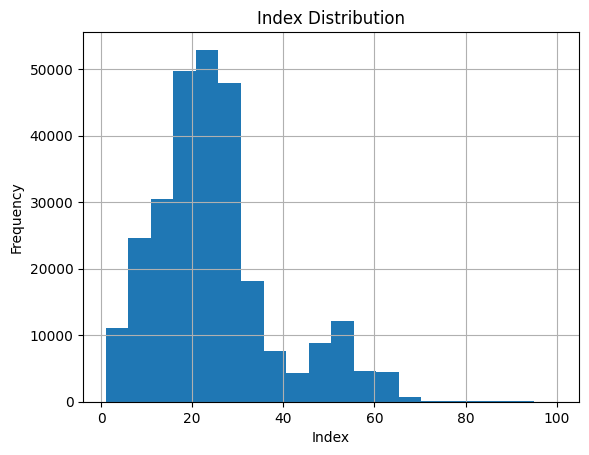

In [25]:
road_gdf["index"].hist(bins=20)
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.title("Index Distribution")
plt.show()

Index(['id', 'name', 'way_type', 'index', 'index_10', 'stress_level', 'offset',
       'side', 'proc_width', 'proc_surface', 'proc_smoothness', 'proc_oneway',
       'proc_sidepath', 'proc_highway', 'proc_maxspeed',
       'proc_traffic_mode_left', 'proc_traffic_mode_right',
       'proc_separation_left', 'proc_separation_right', 'proc_buffer_left',
       'proc_buffer_right', 'proc_mandatory', 'proc_traffic_sign', 'fac_width',
       'fac_surface', 'fac_highway', 'fac_maxspeed', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'data_bonus', 'data_malus',
       'data_incompleteness', 'data_missing', 'data_missing_width',
       'data_missing_surface', 'data_missing_smoothness',
       'data_missing_maxspeed', 'data_missing_parking', 'data_missing_lit',
       'filter_usable', 'filter_way_type', 'layer', 'path', 'geometry'],
      dtype='object')


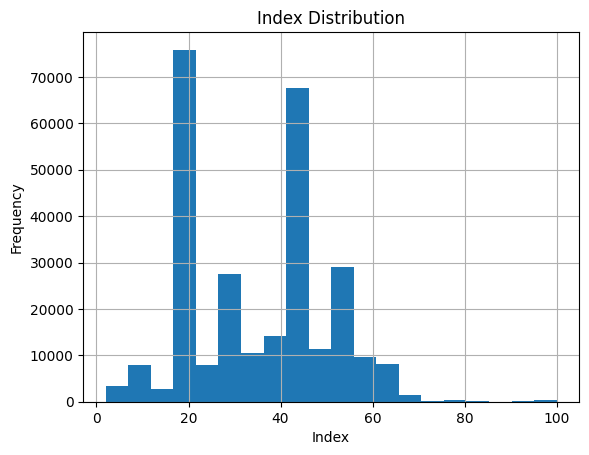

In [26]:
# 我们来比对一下
road_gdf_origin = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA.geojson")
print(road_gdf_origin.columns)

road_gdf_origin["index"].hist(bins=20)
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.title("Index Distribution")
plt.show()

In [30]:
road_gdf["id"].value_counts().head(10)          # 新数据里重复最多的 id

,count
id,
way/1163131192,6
way/1074165933,6
way/656625116,6
way/127497584,6
way/312263564,6
way/1065580322,6
way/497316334,6
way/80130628,6
way/1073109230,6


In [31]:
road_gdf_origin["id"].value_counts().head(10)   # 旧数据里重复最多的 id

,count
id,
way/1163131192,6
way/1074165933,6
way/656625116,6
way/127497584,6
way/312263564,6
way/1065580322,6
way/497316334,6
way/80130628,6
way/1073109230,6


count    326318.000000
mean        -10.146587
std           9.365828
min         -72.000000
25%         -17.000000
50%          -8.000000
75%          -3.000000
max          61.000000
Name: index_diff, dtype: float64
Top↑ 提升最大的10条：
                    id  index_old  index_new  index_diff
216100  way/1018387286          7         68          61
212631  way/1217910151          7         65          58
212637  way/1217910152          7         65          58
214123  way/1052168031          7         65          58
215467  way/1353722381          7         65          58
215474  way/1353658508          7         65          58
216104  way/1018387287          7         65          58
217116  way/1018387289          7         65          58
197603   way/854068960         17         71          54
212751  way/1083449025          7         61          54
Top↓ 降幅最大的10条：
                    id  index_old  index_new  index_diff
206867  way/1278351623         97         25         -72
94834    way

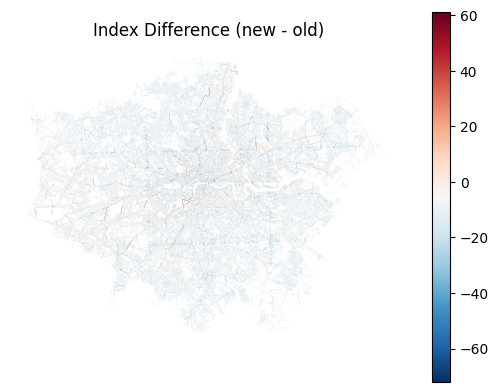

In [27]:
import geopandas as gpd
import pandas as pd

# 1) 只取需要的列并改名，方便区分
g_new = road_gdf[["id", "index", "geometry"]].rename(columns={"index":"index_new"})
g_old = road_gdf_origin[["id", "index"]].rename(columns={"index":"index_old"})

# （可选）如果CRS不一致，统一一下
if g_new.crs != road_gdf_origin.crs:
    g_new = g_new.to_crs(road_gdf_origin.crs)

# 2) 按 id 合并，并计算差值（新-旧：>0代表分数上升，<0代表下降）
g_diff = g_new.merge(g_old, on="id", how="inner")
g_diff["index_diff"] = g_diff["index_new"] - g_diff["index_old"]

# 3) 快速看统计与变化最大的要素
print(g_diff["index_diff"].describe())
print("Top↑ 提升最大的10条：")
print(g_diff.nlargest(10, "index_diff")[["id", "index_old", "index_new", "index_diff"]])
print("Top↓ 降幅最大的10条：")
print(g_diff.nsmallest(10, "index_diff")[["id", "index_old", "index_new", "index_diff"]])

# 4) 静态差值图（红降蓝升），需要 mapclassify 才能用 scheme="quantiles"
ax = g_diff.plot(column="index_diff",
                 cmap="RdBu_r",  # 蓝=上升，红=下降（_r 代表反转）
                 legend=True,
                 linewidth=0.1)
ax.set_title("Index Difference (new - old)")
ax.set_axis_off()

# 5) 导出方便在GIS中做热力对比
out_path = "/content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA_index_diff.geojson"
g_diff.to_file(out_path, driver="GeoJSON")
print(f"差值图层已导出：{out_path}")


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from shapely.geometry import LineString

# ========= 0) 生成差值图层（若你已有 g_diff 可跳过这块） =========
# 假设已有 road_gdf（新）与 road_gdf_origin（旧），都含 id 与 geometry
g_new = road_gdf[["id", "index", "geometry"]].rename(columns={"index":"index_new"})
g_old = road_gdf_origin[["id", "index"]].rename(columns={"index":"index_old"})

# 统一CRS
if g_new.crs != road_gdf_origin.crs:
    g_new = g_new.to_crs(road_gdf_origin.crs)

g_diff = g_new.merge(g_old, on="id", how="inner")
g_diff["index_diff"] = g_diff["index_new"] - g_diff["index_old"]

print("== index_diff 概览 ==")
print(g_diff["index_diff"].describe())


In [28]:
# ========= 1) 区间分布（value_counts with bins） =========
# 自动根据数据范围构造对称分箱（步长=5分，可改）
dmin = np.floor(g_diff["index_diff"].min())
dmax = np.ceil(g_diff["index_diff"].max())
bound = int(max(abs(dmin), abs(dmax)))
step = 5
bins = np.arange(-bound - (bound % step), bound + step, step)  # 对称到零两侧

vc = g_diff["index_diff"].value_counts(bins=bins, sort=False)
dist_df = pd.DataFrame({
    "bin": vc.index.astype(str),
    "count": vc.values
})
dist_df["percent"] = (dist_df["count"] / len(g_diff) * 100).round(2)
print("== index_diff 区间分布（步长=5）==")
print(dist_df)

== index_diff 区间分布（步长=5）==
                 bin  count  percent
0   (-74.001, -69.0]      1     0.00
1     (-69.0, -64.0]     14     0.00
2     (-64.0, -59.0]     12     0.00
3     (-59.0, -54.0]      8     0.00
4     (-54.0, -49.0]     25     0.01
5     (-49.0, -44.0]    317     0.10
6     (-44.0, -39.0]   1273     0.39
7     (-39.0, -34.0]    759     0.23
8     (-34.0, -29.0]   3251     1.00
9     (-29.0, -24.0]  15870     4.86
10    (-24.0, -19.0]  54951    16.84
11    (-19.0, -14.0]  51904    15.91
12     (-14.0, -9.0]  25490     7.81
13      (-9.0, -4.0]  65551    20.09
14       (-4.0, 1.0]  94195    28.87
15        (1.0, 6.0]   6709     2.06
16       (6.0, 11.0]   3431     1.05
17      (11.0, 16.0]    702     0.22
18      (16.0, 21.0]    300     0.09
19      (21.0, 26.0]    328     0.10
20      (26.0, 31.0]    442     0.14
21      (31.0, 36.0]    566     0.17
22      (36.0, 41.0]    195     0.06
23      (41.0, 46.0]     12     0.00
24      (46.0, 51.0]      0     0.00
25      (51

In [ ]:
# ========= 2) 按 Borough 聚合平均变化 =========
# 👉 将路径替换为你的 Borough 边界文件（GeoJSON/GeoPackage/Shapefile 都可）
BORO_PATH = "/content/drive/MyDrive/CASA0004_Cycling/data/Admin/London_Borough_Boundaries.geojson"
boroughs = gpd.read_file(BORO_PATH)

# 统一CRS后做空间连接
if boroughs.crs != g_diff.crs:
    boroughs = boroughs.to_crs(g_diff.crs)

# 可能的名称字段
name_cols = [c for c in boroughs.columns if c.lower() in ("name", "borough", "borough_name", "la_name")]
if not name_cols:
    raise ValueError("在 Borough 图层中没有找到名称字段（name/borough/borough_name/la_name），请检查并修改代码。")
BORO_NAME_COL = name_cols[0]

# 空间连接，将每条线归到所在 Borough（交集即可）
g_join = gpd.sjoin(g_diff, boroughs[[BORO_NAME_COL, "geometry"]], how="left", predicate="intersects")
boro_agg = (
    g_join
    .groupby(BORO_NAME_COL)
    .agg(
        mean_index_diff=("index_diff", "mean"),
        median_index_diff=("index_diff", "median"),
        n_links=("id", "count")
    )
    .sort_values("mean_index_diff", ascending=False)
    .round(2)
)
print("== Borough 平均变化（由高到低）==")
print(boro_agg.head(10))
print("== Borough 平均变化（下降最明显）==")
print(boro_agg.tail(10))

# 导出 Borough 聚合表与带属性的区划
boroughs_out = boroughs.merge(boro_agg, on=BORO_NAME_COL, how="left")
boroughs_csv = "/content/drive/MyDrive/CASA0004_Cycling/data/Roads/borough_index_diff_summary.csv"
boroughs_gj  = "/content/drive/MyDrive/CASA0004_Cycling/data/Roads/borough_index_diff.geojson"
boro_agg.to_csv(boroughs_csv, encoding="utf-8")
boroughs_out.to_file(boroughs_gj, driver="GeoJSON")
print(f"Borough 聚合已导出:\n- {boroughs_csv}\n- {boroughs_gj}")

# ========= 3) 只渲染显著变化（|diff| >= 5）到 Folium =========
sig = g_diff.loc[g_diff["index_diff"].abs() >= 5].copy()
print(f"显著变化要素数: {len(sig)}")

# Folium 需要 WGS84
sig_4326 = sig.to_crs(epsg=4326)

# 简单的颜色映射：上升=蓝，下降=红
def color_by_diff(d):
    return "#2b8cbe" if d >= 0 else "#de2d26"

# 可选：限制最大渲染数量，避免浏览器过重（比如只取|diff|最大的2万条）
MAX_FEATS = 20000
if len(sig_4326) > MAX_FEATS:
    sig_4326 = sig_4326.reindex(
        sig_4326["index_diff"].abs().sort_values(ascending=False).index[:MAX_FEATS]
    )

# 地图中心
if not sig_4326.empty:
    center = [sig_4326.geometry.iloc[0].centroid.y, sig_4326.geometry.iloc[0].centroid.x]
else:
    center = [51.5074, -0.1278]  # 伦敦

m = folium.Map(location=center, zoom_start=11, tiles="cartodbpositron")

# 上升与下降分两层
up = sig_4326[sig_4326["index_diff"] >= 0]
down = sig_4326[sig_4326["index_diff"] < 0]

def add_geojson_lines(gdf, name, color, map_obj, weight=3, opacity=0.7):
    folium.GeoJson(
        gdf.to_json(),
        name=name,
        style_function=lambda f: {"color": color, "weight": weight, "opacity": opacity},
        tooltip=folium.features.GeoJsonTooltip(
            fields=["id", "index_old", "index_new", "index_diff"],
            aliases=["id", "old", "new", "diff"],
            sticky=True
        )
    ).add_to(map_obj)

if not up.empty:
    add_geojson_lines(up, "Increase (>= +5)", "#2b8cbe", m)
if not down.empty:
    add_geojson_lines(down, "Decrease (<= -5)", "#de2d26", m)

folium.LayerControl().add_to(m)

html_out = "/content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA_index_diff_hotspots.html"
m.save(html_out)
print(f"显著变化热点地图已导出: {html_out}")

# ========= 4) 额外：导出显著变化矢量，便于GIS叠加 =========
sig_out = "/content/drive/MyDrive/CASA0004_Cycling/data/Roads/AAA_index_diff_significant.geojson"
sig.to_file(sig_out, driver="GeoJSON")
print(f"显著变化矢量已导出: {sig_out}")
